In [1]:
import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import SecondGeometry, LinearField
from learn_embedding.utils import *

## Torch Configuration

In [2]:
use_cuda = False # torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Create Model

In [3]:
dim = 2
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
approximator = FeedForward(dim, [64], 1)

embedding = Embedding(approximator)
TorchHelper.set_zero(embedding)

stiffness = Spherical(1, False)
dissipation = Spherical(2, False)

attractor = torch.tensor([0.0,0.0]).to(device)

field = LinearField(attractor, Spherical(0.5, False))

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
model.velocity_embedding = False

## Test

In [4]:
resolution = 100
min_ax = torch.tensor([-1,-1])
max_ax = torch.tensor([1,1])
y, x = torch.meshgrid(torch.linspace(min_ax[1], max_ax[1], resolution), torch.linspace(min_ax[0], max_ax[0], resolution))

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

/home/bernardo/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Potential

Text(0.5, 1.0, 'Potential Function $\\phi$')

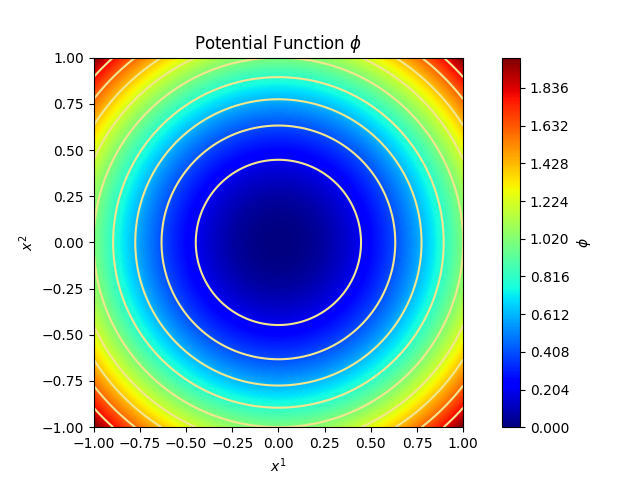

In [5]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()
norm = matplotlib.colors.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(im, ax=ax, label=r"$\phi$")
ax.axis("square")
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_title('Potential Function $\phi$')

### Vector Field & Streamlines

Text(0.5, 1.0, 'Vector Field')

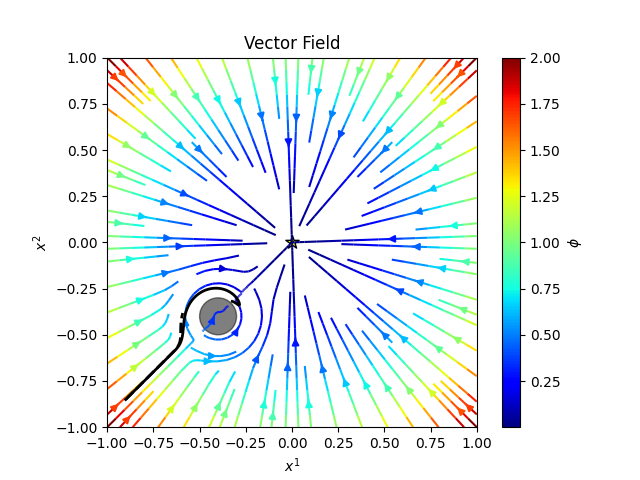

In [6]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
embedding.local_deformation = phi

field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = torch.tensor([[-0.9, -0.85, 1, 1]]).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=x0,T=5.0, dt=0.01).cpu().detach().numpy()
geodesic = Integrator.second_order(dynamics=model.geodesic,x0=x0,T=1.0, dt=0.01).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet")
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth='2')
    ax.plot(geodesic[:, i, 0], geodesic[:, i, 1], color='k', linestyle='dashed', linewidth='2')

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)

ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
ax.axis("square")
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(mappable,  ax=ax, label=r"$\phi$")
ax.set_title('Vector Field')

### Embedding

Text(0.5, 0.92, 'Embedding Space')

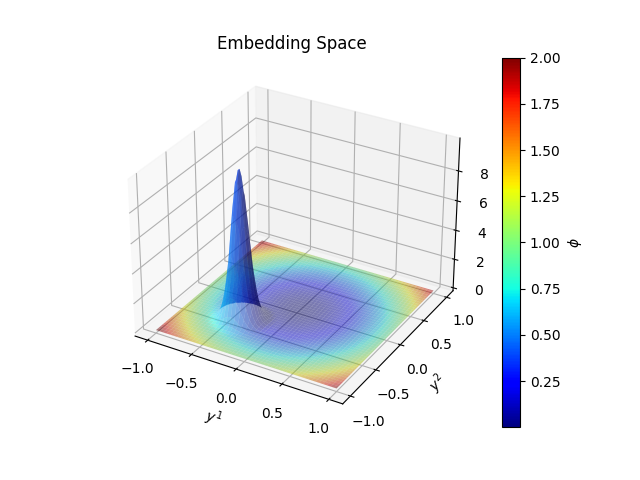

In [7]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.plot_surface(x_embedding, y_embedding, z_embedding,facecolors=colors, antialiased=True, linewidth=0, alpha=0.5)
ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')
fig.colorbar(mappable, ax=ax, label=r"$\phi$")
ax.set_title('Embedding Space')

### Metric

Text(0.5, 1.0, 'Metric Determinant')

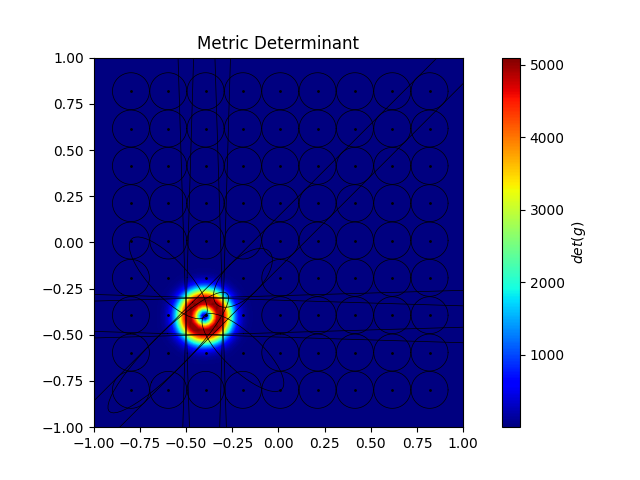

In [8]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/10
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

norm = matplotlib.colors.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x, y, det_metric, 500, cmap="jet")
ax.scatter(x[10::10,10::10,], y[10::10,10::10], color="k", s=1)

for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i,:], ellipses_y[i,:], color="k", linewidth=0.5)

fig.colorbar(mappable,  ax=ax, label=r"$det(g)$")
ax.axis('square')
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_title('Metric Determinant')

### Christoffel Symbols

Text(0.5, 1.0, 'Sampled Trajectory with Christoffel Ellipses')

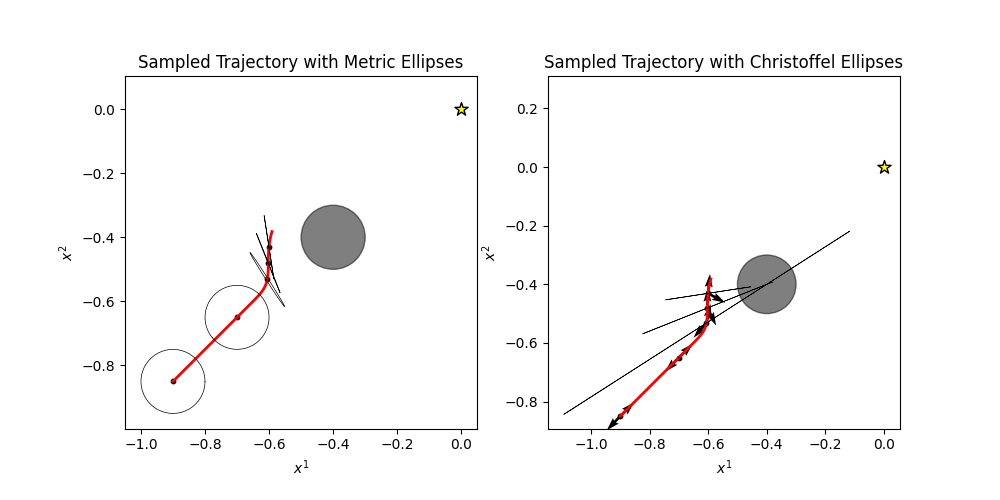

In [41]:
step = 20
eval_scale = 10
trajectory = geodesic # streamlines
x_sampled = torch.from_numpy(trajectory[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(trajectory[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale

christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
# ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='k', linewidth='2')
ax.plot(trajectory[:, 0, 0], trajectory[:, 0, 1], color='r', linewidth='2')
ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=10)
for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=0.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
ax.axis('square')
# ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
# ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_title('Sampled Trajectory with Metric Ellipses')

ax = fig.add_subplot(122)
# ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='k', linewidth='2')
ax.plot(trajectory[:, 0, 0], trajectory[:, 0, 1], color='r', linewidth='2')
ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=10)
for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=0.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
acc = model(torch.cat((x_sampled[::step],v_sampled[::step]),dim=1))
acc = acc/acc.norm(dim=1).unsqueeze(-1)
vel = v_sampled[::step]/v_sampled[::step].norm(dim=1).unsqueeze(-1)
ax.quiver(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(),acc[:,0].detach().cpu(), acc[:,1].detach().cpu())
ax.quiver(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(),vel[:,0].detach().cpu(), vel[:,1].detach().cpu())
ax.axis('square')
# ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
# ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_title('Sampled Trajectory with Christoffel Ellipses')

tensor([[  2.7000,   2.5500],
        [  2.6700,   2.5200],
        [  2.6400,   2.4900],
        [  2.6100,   2.4600],
        [  2.5800,   2.4300],
        [  2.5500,   2.4000],
        [  2.5200,   2.3700],
        [  2.4900,   2.3400],
        [  2.4600,   2.3100],
        [  2.4300,   2.2800],
        [  2.4000,   2.2500],
        [  2.3700,   2.2200],
        [  2.3400,   2.1900],
        [  2.3100,   2.1600],
        [  2.2800,   2.1300],
        [  2.2500,   2.1000],
        [  2.2200,   2.0700],
        [  2.1899,   2.0399],
        [  2.1596,   2.0097],
        [  2.1282,   1.9785],
        [  2.0926,   1.9439],
        [  2.0413,   1.8963],
        [  1.9351,   1.8039],
        [  1.6524,   1.5686],
        [  0.8630,   0.9278],
        [ -1.0926,  -0.6341],
        [ -4.7042,  -3.4748],
        [ -8.9507,  -6.7471],
        [-12.1833,  -9.1523],
        [-14.1053, -10.4886],
        [-15.1451, -11.1161],
        [-15.6820, -11.3435],
        [-15.9394, -11.3506],
        [-

In [10]:
torch.linalg.eig(metric_sampled[40])

torch.return_types.linalg_eig(
eigenvalues=tensor([30.2079+0.j,  1.0000+0.j], grad_fn=<LinalgEigBackward0>),
eigenvectors=tensor([[ 0.8420+0.j, -0.5396+0.j],
        [ 0.5396+0.j,  0.8420+0.j]], grad_fn=<LinalgEigBackward0>))

In [11]:
1/9.5129

0.1051204154358818

In [12]:
dist = x_sampled[40] - obstacle

In [13]:
dist.norm()

tensor(0.2443, grad_fn=<NormBackward1>)

In [14]:
k=SquaredExp(l=lengthscale)

In [15]:
k(x_sampled[40].unsqueeze(0), obstacle)

tensor([[0.0160]], grad_fn=<ExpBackward0>)

In [16]:
dist

tensor([[-0.2057, -0.1318]], grad_fn=<SubBackward0>)

In [17]:
dev = -dist*k(x_sampled[40].unsqueeze(0), obstacle)/np.power(lengthscale, 2)*10

In [18]:
jac = model.embedding.jacobian(x_sampled, sampled_embedding)

In [19]:
metric_sampled[40]

tensor([[21.7049, 13.2685],
        [13.2685,  9.5030]], grad_fn=<SelectBackward0>)

In [20]:
torch.mm(dev.T, dev)

tensor([[20.7050, 13.2686],
        [13.2686,  8.5030]], grad_fn=<MmBackward0>)

In [21]:
torch.mm(dist.T, dist)*k(x_sampled[40].unsqueeze(0), obstacle).square()/np.power(lengthscale, 4)*100

tensor([[20.7050, 13.2686],
        [13.2686,  8.5030]], grad_fn=<MulBackward0>)

In [22]:
d = torch.linspace(0,1,1000)
# d = torch.tensor([0.2640])
val = 1 + d.square() * torch.exp(-0.5*d.square()/lengthscale**2).square()/np.power(lengthscale, 4)*100

In [23]:
val

tensor([1.0000e+00, 2.9254e+00, 8.6984e+00, 1.8309e+01, 3.1742e+01, 4.8975e+01,
        6.9978e+01, 9.4717e+01, 1.2315e+02, 1.5523e+02, 1.9091e+02, 2.3012e+02,
        2.7280e+02, 3.1889e+02, 3.6829e+02, 4.2094e+02, 4.7675e+02, 5.3562e+02,
        5.9746e+02, 6.6216e+02, 7.2963e+02, 7.9976e+02, 8.7242e+02, 9.4750e+02,
        1.0249e+03, 1.1045e+03, 1.1861e+03, 1.2696e+03, 1.3549e+03, 1.4419e+03,
        1.5304e+03, 1.6203e+03, 1.7114e+03, 1.8037e+03, 1.8968e+03, 1.9908e+03,
        2.0855e+03, 2.1807e+03, 2.2763e+03, 2.3721e+03, 2.4680e+03, 2.5639e+03,
        2.6597e+03, 2.7551e+03, 2.8500e+03, 2.9444e+03, 3.0380e+03, 3.1308e+03,
        3.2226e+03, 3.3133e+03, 3.4028e+03, 3.4909e+03, 3.5775e+03, 3.6626e+03,
        3.7460e+03, 3.8276e+03, 3.9074e+03, 3.9851e+03, 4.0607e+03, 4.1342e+03,
        4.2054e+03, 4.2743e+03, 4.3408e+03, 4.4048e+03, 4.4662e+03, 4.5250e+03,
        4.5812e+03, 4.6347e+03, 4.6853e+03, 4.7332e+03, 4.7782e+03, 4.8204e+03,
        4.8596e+03, 4.8959e+03, 4.9293e+